<a href="https://colab.research.google.com/github/viriditass/Papers/blob/main/Focal_Loss_for_Dense_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Focal Loss for Dense Object Detection**

논문 링크: https://arxiv.org/abs/1708.02002

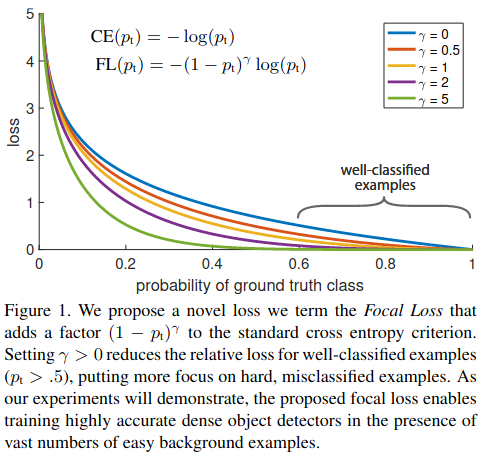

논문이 나온 시점까지 one-stage Network(Dense Object Detector)는 two-stage에 비해 빠르지만 성능이 낮았다. 본 논문에서는 성능이 낮은 원인을 **class imbalance** 문제라고 지적한다. 그리고 이를 해결하기 위해 cross entropy를 조금 수정한 **Focal loss**를 제안한다.

먼저, 왜 class imbalance 문제가 one-stage에게 더욱 치명적인지부터 알아보겠다.

R-CNN과 같은 two-stage detector들은 **two-stage cascade**나 **sampling heuristics**를 사용해 class imbalance 문제를 완화했는데, proposal 단계에서 **Selective Search**나 **EdgeBoxes**, **DeepMask**, **FPN** 등이 background를 필터링하고 두 번째 분류 단계에서 foreground-to-background ratio가 1:3이 되도록 조정하거나 online hard example mining(OHEM) 등의 sampling heuristic 방법을 사용하기 때문에 foreground와 background의 class balance가 맞춰진다.

이와는 대조적으로 one-stage detector는 이미지 전체에 object 후보들이 매우 많이 나온다. Train 과정에서 loss가 너무 많은 backgound examples에 의해 압도되어 버리기 때문에 단순 R-CNN 등에서 사용하는 sampling 기법을 적용하는 것만으로는 해결되지 않는다.

이러한 문제점을 해결하기 위해 나온 것이 바로 Focal loss이다.

## **Focal Loss**

Focal loss는 동적(Dynimic)으로 cross entropy loss의 크기를 조절한다. 맨 위의 그림 Figure 1를 보면 알 수 있듯이 class classification이 잘 된 example에 대해서는 scaling factor가 거의 0에 가까워진다. 즉, simple example에 대해서는 학습에 기여도를 낮춘다.(=down-weight) 반면, hard example에 대해서는 학습 기여도를 높인다. (=up-weight)

이제 바로 Focal loss의 수식을 살펴보겠다. 수식을 살펴보기 앞서 focal loss는 foreground와 background의 class 간의 imbalance가 매우 심한(Ex. 1:1000)을 해결하기 위해 디자인됬다는 것을 명심하자.

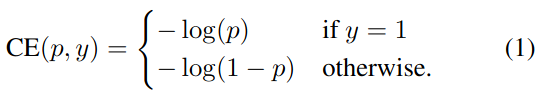

위의 식은 그냥 Cross entropy이다.

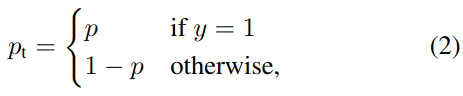

아래 식은 좀더 도식화를 편하게 하기 위헤 넣은 것으로, **CE(p,y) = CE(P_t) = -log(P_t)** 이다.

CE Loss는 맨 위의 그림 Figure 1의 blue cuve 형태를 갖는다. CE loss의 가장 눈에 띄는 특징은 easy sample(P_t >> 0.5)의 loss가 그다지 작지 않다는 점이다. 즉, 이들의 loss가 커지게 되면 드문 class들의 loss가 압도 당할 수 있다.

### **Balanced Cross Entropy**

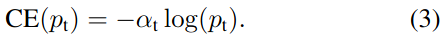

이러한 문제를 해결하기 가장 쉬운 방법은 위의 식과 같이 가중치 α를 줌으로써 해결하는 것이다. 클래스 1에는 α를 클래스 -1에는 α-1를 적용한다.

### **Focal Loss Definition**

방금 언급한 식에서 easy / hard sample에 각각 적합한 α값을 넣어준다고 하였다. 그러나 단순 저 식만으로는 α가 easy / hard를 구분할 수 없다.

따라서 본 논문은 easy sample의 중요도를 down-weight 시킬 cross entropy의 조절 항 (1-p_t)^γ를 추가했다. γ는 조절 가능한 focusing parameter로 (>= 0)의 값을 갖는다.

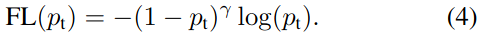

위의 식과 같이 focal loss를 정의한다. 만일 example을 잘못 분류해도 P_t 값이 작은 경우는 조절 항이 1에 가까워지면서 값이 거의 0이 되므로 loss에 영향을 주지 않는다. 또한, easy sample 역시 down-weight 시킨다.

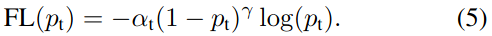

최종적인 loss는 위와 같이 된다. 추가적으로 마지막 loss layer에서 sigmoid operation을 사용할 때 가장 좋은 성능을 얻었다.

### **Class Imbalance and Model Initialization**

기본적으로 binary classification model은 class y가 -1일 확률과 1일 확률이 같도록 initialization을 한다. 그러나, 이렇게 초기화하고 class imbalance 현상이 나타나게 되면 더 많은 class가 total loss에 더 많은 비중을 차지해 학습이 초기부터 불안정해진다.

따라서, 이를 해결하기 위해 p(=prior)를 사용했다. p는 rate class(foreground)의 비율로 최초 학습시에 사용하는 값이다. p항은 단순히 model initialization에 사용하는 것이다. class imbanace가 심한 경우에 cross entropy나 focal loss 등에 관계없이 학습 안정화에 도움을 준다.

## **RetinaNet Detector**

RetinaNet은 하나로 통합된 network로 backbone network와 2개의 전용 subnetwork로 구성된다. backbone은 input image의 total region에 대해 convolutional feature map을 계산하는 역할이며, 첫 번째 subnet은 backbone output으로 부터 object classification을 수행하고 두 번째 subnet은 backbone output으로 부터 bbox의 좌표를 구한다.

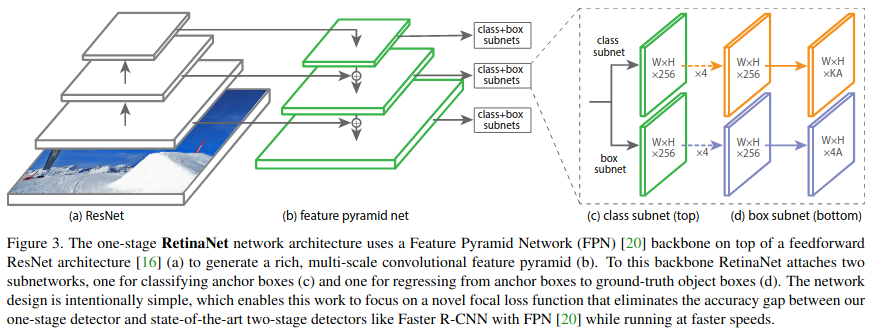

RetinaNet의 구조는 위의 그림 Figure 3과 같다. RetinaNet에 대한 설명은 본 논문에서도 언급했듯이 애초에 본 논문이 새로운 model architecture를 제안하는 것이 목적이 아니라서 간단하게 디자인 했다고 하니 skip하겠다.

## **Experiments**

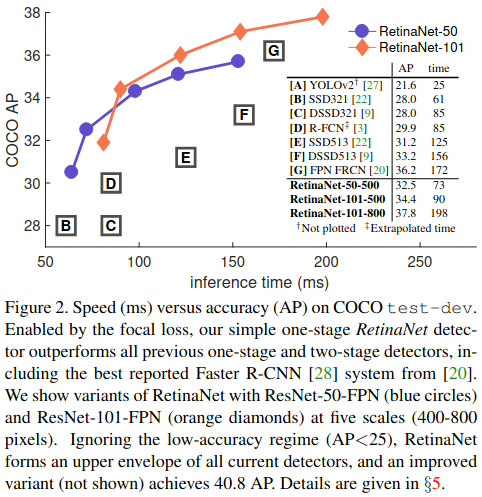

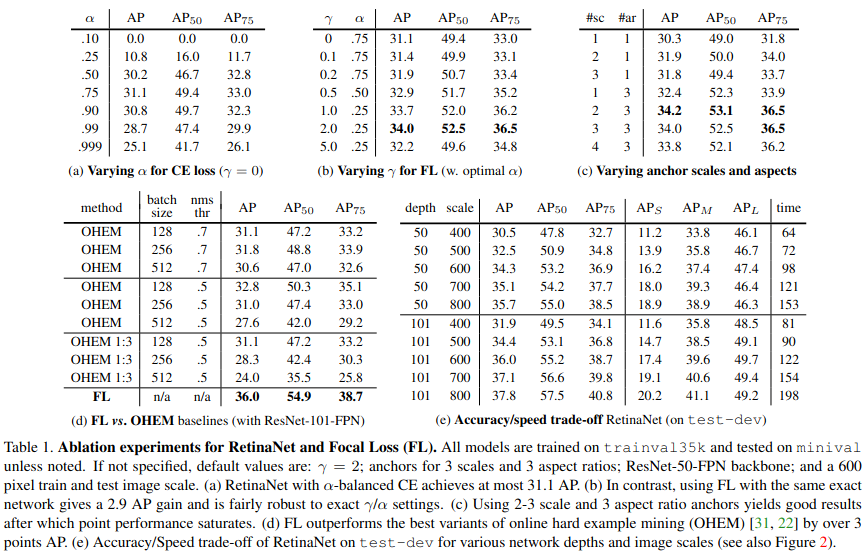